In [26]:
from google.colab import files
import os
import shutil

# Upload the file
uploaded = files.upload()

# Get the filename (should be 'kaggle.json')
filename = next(iter(uploaded))

# Create the .kaggle directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Move the file to the kaggle folder
shutil.move(filename, os.path.expanduser("~/.kaggle/kaggle.json"))

# Set correct permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


Saving kaggle.json to kaggle.json


In [27]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [28]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources


Dataset URL: https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources
License(s): CC0-1.0
tomato-disease-multiple-sources.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
!unzip -q tomato-disease-multiple-sources.zip -d tomato_disease_data


replace tomato_disease_data/train/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [30]:
import os

dataset_path = 'tomato_disease_data'
print("Folders inside:", os.listdir(dataset_path))


Folders inside: ['valid', 'train']


In [31]:
import os

# Look inside the base unzip folder
print("Unzipped folders:", os.listdir('tomato_disease_data'))


Unzipped folders: ['valid', 'train']


In [32]:
import os

train_dir = 'tomato_disease_data/train'
print("Folders in train/:")
print(os.listdir(train_dir))


Folders in train/:
['Spider_mites Two-spotted_spider_mite', 'Septoria_leaf_spot', 'Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy', 'Bacterial_spot', 'Target_Spot', 'Early_blight', 'Tomato_mosaic_virus', 'Leaf_Mold', 'powdery_mildew']


In [33]:
import os
import shutil

original_dir = 'tomato_disease_data/train'
new_dir = 'tomato_disease_data_filtered/train'
selected_classes = ['Tomato_mosaic_virus', 'Septoria_leaf_spot', 'powdery_mildew']

os.makedirs(new_dir, exist_ok=True)

for class_name in selected_classes:
    src = os.path.join(original_dir, class_name)
    dst = os.path.join(new_dir, class_name)
    if not os.path.exists(dst):
        shutil.copytree(src, dst)


In [34]:
import tensorflow as tf

train_dir = 'tomato_disease_data_filtered/train'
batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Filtered class names:", class_names)


Found 6039 files belonging to 3 classes.
Filtered class names: ['Septoria_leaf_spot', 'Tomato_mosaic_virus', 'powdery_mildew']


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Paths and params
train_dir = 'tomato_disease_data_filtered/train'
img_size = (224, 224)
batch_size = 32

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 6039 files belonging to 3 classes.
Using 4832 files for training.
Found 6039 files belonging to 3 classes.
Using 1207 files for validation.
Classes: ['Septoria_leaf_spot', 'Tomato_mosaic_virus', 'powdery_mildew']


In [37]:
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Load base model with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

# Build the model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Apply it to your training dataset like:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)




Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7509 - loss: 0.5863 - val_accuracy: 0.9097 - val_loss: 0.2111
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9177 - loss: 0.1984 - val_accuracy: 0.9362 - val_loss: 0.1585
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9389 - loss: 0.1499 - val_accuracy: 0.9147 - val_loss: 0.2269
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9499 - loss: 0.1321 - val_accuracy: 0.9470 - val_loss: 0.1346
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.9538 - loss: 0.1098 - val_accuracy: 0.9519 - val_loss: 0.1386
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.9660 - loss: 0.0979 - val_accuracy: 0.9478 - val_loss: 0.1443
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9664 - loss: 0.0816 - val_accuracy: 0.9635 - val_loss: 0.1062
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9672 - loss: 0.0804 - val_accu

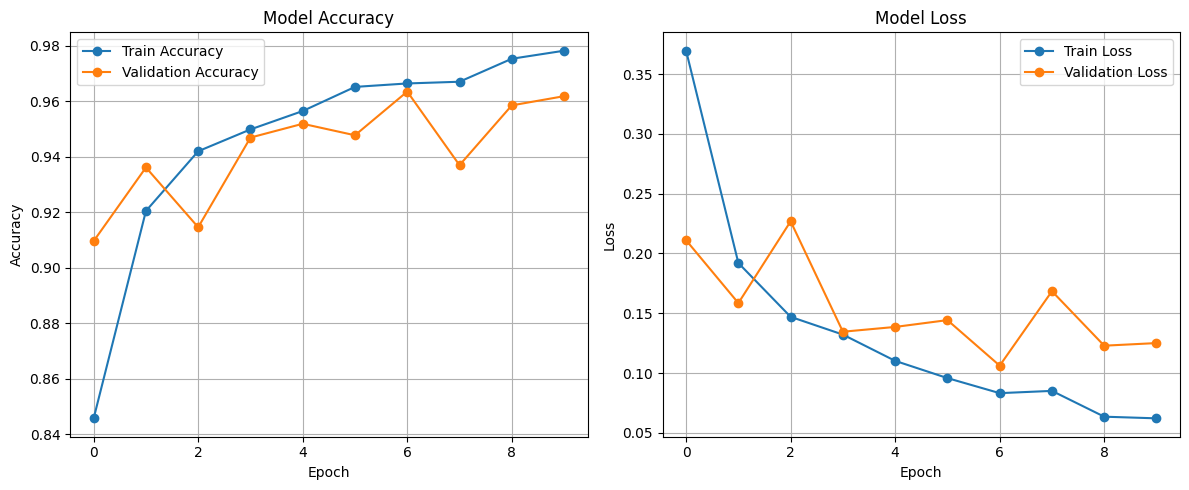

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the trained model
model.save('/content/drive/MyDrive/tomato_disease_model.h5')



# Load from folder
model.save('/content/drive/MyDrive/my_model.h5')


# Load from .h5 file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {train_acc:.2f}")
print(f"✅ Final Validation Accuracy: {val_acc:.2f}")

✅ Final Training Accuracy: 0.98
✅ Final Validation Accuracy: 0.96


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount and load model
drive.mount('/content/drive')
model = load_model('/content/drive/MyDrive/tomato_disease_model.h5')



# Define class names manually (or load from file)
class_names = ['Septoria_leaf_spot', 'Tomato_mosaic_virus', 'powdery_mildew']

def classify_leaf(img):
    if img is None:
        return "Error: No image received. Please upload a valid image."

    img = img.copy().resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = float(np.max(prediction))

    return f"{predicted_class} ({confidence:.2%})"

# Launch Gradio interface
interface = gr.Interface(
    fn=classify_leaf,
    inputs=gr.Image(type="pil"),
    outputs="label",
    live=False,
    allow_flagging="never",
    analytics_enabled=False
)

interface.launch(debug=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dc77b92b0aae8f41bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
